In [1]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
import pymc as pm
import networkx as nx
import numpy as np
import arviz as az
import aesara.tensor as at
import matplotlib.pyplot as plt
import pymc.math as pmm

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


point={'sigma_traffic_log__': array(0.), 'alpha_traffic': array(50.), 'beta_time': array(0.), 'beta_seasonal': array(10.), 'beta_risk_1': array(0.), 'beta_traffic_1': array(0.), 'beta_weather_1': array(0.), 'beta_risk_2': array(0.), 'beta_traffic_2': array(0.), 'beta_weather_2': array(0.)}



/opt/conda/envs/jupyter-env/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


No problems found


INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:NUTS: [sigma_traffic, alpha_traffic, beta_time, beta_seasonal, beta_risk_1, beta_traffic_1, beta_weather_1, beta_risk_2, beta_traffic_2, beta_weather_2]


Output()

INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 42 seconds.


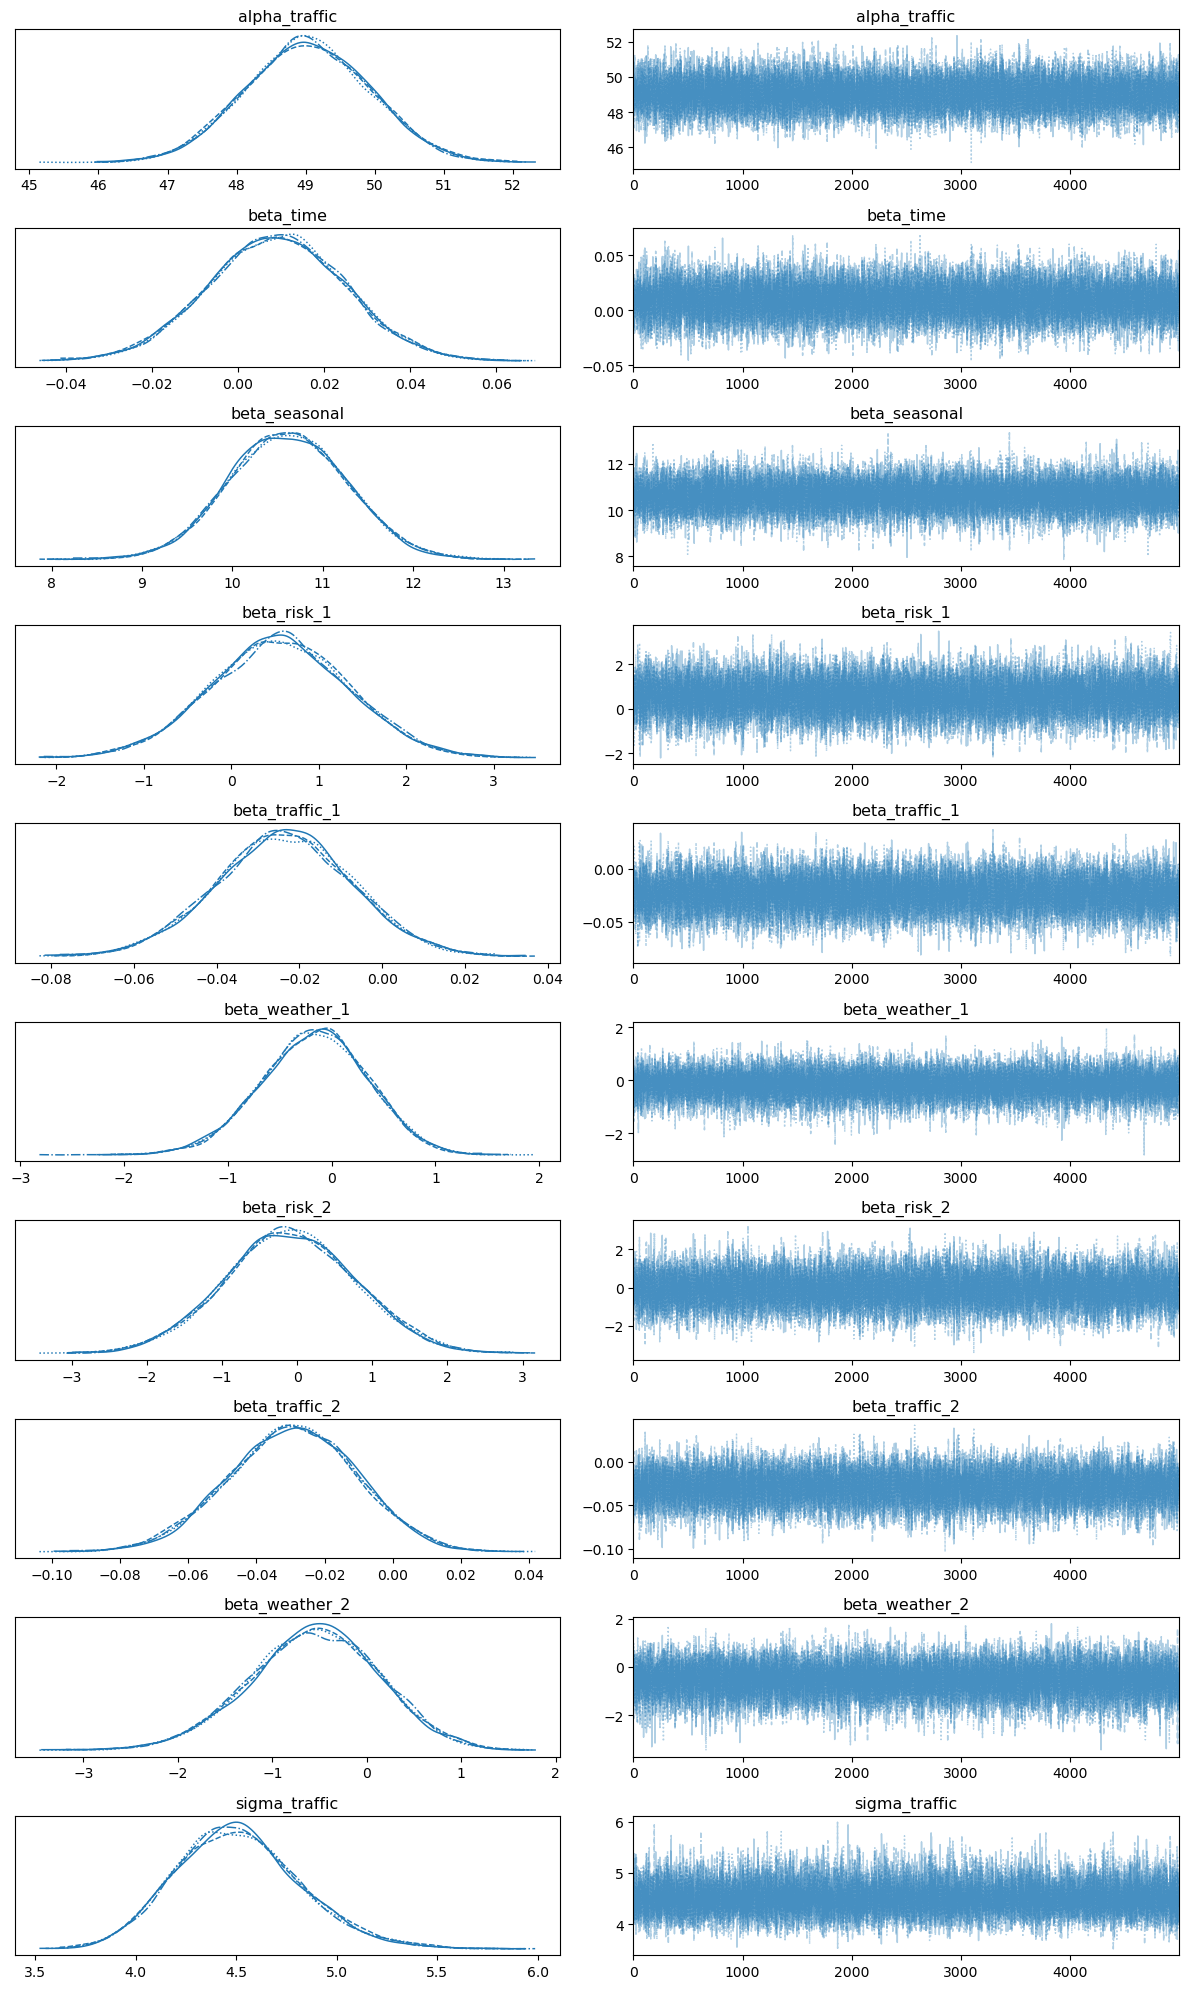

In [2]:
# Build PyMC model
# Simulate data
np.random.seed(42)
n_samples = 100
time = np.arange(n_samples)

# Simulated traffic data with a periodic pattern
traffic_data = 50 + 10 * np.sin(2 * np.pi * time / 24) + np.random.normal(0, 5, n_samples)
# Simulated weather data (binary: 0 = Bad Weather, 1 = Good Weather)
weather_data = np.random.binomial(1, 0.2, n_samples)  # 20% chance of good weather
# Simulated risk data (0 = Low, 1 = Medium, 2 = High)
risk_data = np.random.choice([0, 1, 2], size=n_samples, p=[0.6, 0.3, 0.1])

with pm.Model() as model:

    # -------------------------
    # 1. Time Series Modeling for Traffic Forecasting
    # -------------------------

    # Prior for traffic fluctuation (uncertainty in the model)
    sigma_traffic = pm.Exponential("sigma_traffic", 1.0)

    # Priors for the trend and seasonal effects
    alpha_traffic = pm.Normal("alpha_traffic", mu=50, sigma=10)  # Baseline traffic level
    beta_time = pm.Normal("beta_time", mu=0, sigma=1)  # Trend effect (increase or decrease over time)
    beta_seasonal = pm.Normal("beta_seasonal", mu=10, sigma=5)  # Seasonal effect (e.g., daily peaks)

    # Traffic forecast equation: Trend + Seasonality
    mu_traffic = alpha_traffic + beta_time * time + beta_seasonal * pm.math.sin(2 * np.pi * time / 24)

    # Observed traffic data modeled as a normal distribution
    obs_traffic = pm.Normal("obs_traffic", mu=mu_traffic, sigma=sigma_traffic, observed=traffic_data)
    
    # -------------------------
    # 2. Logistic Regression for Risk Prediction
    # -------------------------

    # Priors for risk prediction model
    # Coefficients for each class (except the reference class, which is 0)
    # For predicting class 1 (Medium risk)
    beta_risk_1 = pm.Normal("beta_risk_1", mu=0, sigma=1)           # Intercept term for class 1
    beta_traffic_1 = pm.Normal("beta_traffic_1", mu=0, sigma=1)     # Coefficient for traffic effect on class 1
    beta_weather_1 = pm.Normal("beta_weather_1", mu=0, sigma=1)     # Coefficient for weather effect on class 1
    
    # For predicting class 2 (High risk)
    beta_risk_2 = pm.Normal("beta_risk_2", mu=0, sigma=1)           # Intercept term for class 2
    beta_traffic_2 = pm.Normal("beta_traffic_2", mu=0, sigma=1)     # Coefficient for traffic effect on class 2
    beta_weather_2 = pm.Normal("beta_weather_2", mu=0, sigma=1)     # Coefficient for weather effect on class 2


    # Linear predictors for Medium (1) and High (2) risk
    traffic_data_shared = pm.Data("traffic_data", traffic_data)
    weather_data_shared = pm.Data("weather_data", weather_data)
    
    logits_1 = beta_risk_1 + beta_traffic_1 * traffic_data_shared + beta_weather_1 * weather_data_shared
    logits_2 = beta_risk_2 + beta_traffic_2 * traffic_data_shared + beta_weather_2 * weather_data_shared

    # Ensure logits_1 and logits_2 have the same shape as logits_0 for concatenation
    logits_1_r = pmm.broadcast_to(logits_1[:, None], (n_samples, 1))     # Equivalent to reshaping (n_samples, 1)
    logits_2_r = pmm.broadcast_to(logits_2[:, None], (n_samples, 1))     # Equivalent to reshaping (n_samples, 1)
    
    logits_0 = pmm.zeros((n_samples, 1), dtype=logits_1.dtype)
    
    # Concatenate logits_0, logits_1_r, logits_2_r
    logits = pmm.concatenate([logits_0, logits_1_r, logits_2_r], axis=1)
    
    # Apply softmax to get class probabilities
    p_risk = pmm.softmax(logits, axis=-1)

    # Observed risk data:  Multi-class Classification
    obs_risk = pm.Categorical("obs_risk", p=p_risk, observed=risk_data)     # The observed 'risk_data' represents the true labels for each sample (0 = Low, 1 = Medium, 2 = High).

    model.debug()

    # -------------------------
    # 3. Monte Carlo Sampling (MCMC)
    # -------------------------

    # Use Markov Chain Monte Carlo (MCMC) to sample from the posterior distribution
    trace = pm.sample(5000, return_inferencedata=True, target_accept=0.95)

# Visualize the MCMC sampling results using ArviZ's plot_trace function.
# This function generates trace plots for each parameter, showing how the parameter values change across multiple sampling steps.
# It helps us assess whether the model has converged, whether the sampling chains are mixing well, and whether there are any signs of bias or poor mixing.
# The x-axis represents the sampling steps, and the y-axis represents the parameter values.
# These plots allow us to evaluate the posterior distribution of each parameter.
az.plot_trace(trace)
plt.tight_layout()
plt.show()

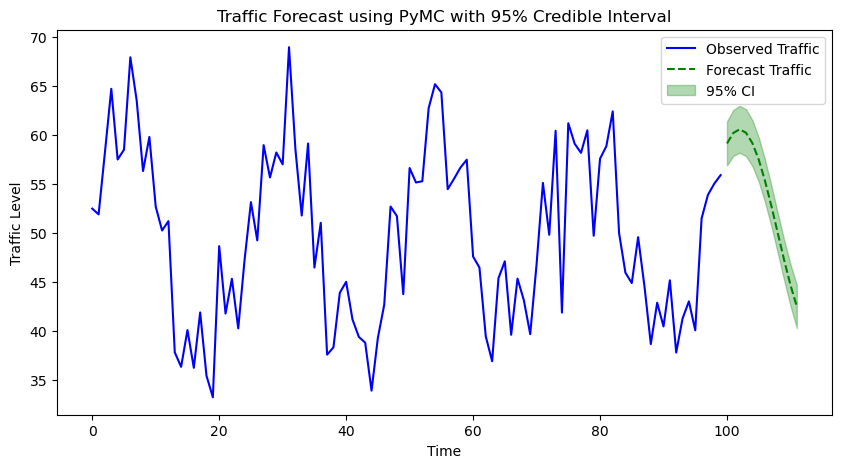

In [10]:
# Forecasting Traffic for Future Periods

# Generate future time points (next 12 days)
forecast_x = np.arange(len(traffic_data), len(traffic_data) + 12)

# Extract posterior samples
alpha_samples = trace.posterior["alpha_traffic"].stack(sample=("chain", "draw")).values
beta_time_samples = trace.posterior["beta_time"].stack(sample=("chain", "draw")).values
beta_seasonal_samples = trace.posterior["beta_seasonal"].stack(sample=("chain", "draw")).values

# Compute forecast mean (for line plot)
alpha_mean = alpha_samples.mean()
beta_time_mean = beta_time_samples.mean()
beta_seasonal_mean = beta_seasonal_samples.mean()

forecast_y_traffic = alpha_mean + beta_time_mean * forecast_x + beta_seasonal_mean * np.sin(2 * np.pi * forecast_x / 24)

# Compute forecast samples for credible interval
N = alpha_samples.shape[0]
forecast_x_expanded = np.tile(forecast_x, (N, 1))
forecast_samples_traffic = (
    alpha_samples[:, None] +
    beta_time_samples[:, None] * forecast_x_expanded +
    beta_seasonal_samples[:, None] * np.sin(2 * np.pi * forecast_x_expanded / 24)
)

# Compute 95% credible interval
forecast_low = np.percentile(forecast_samples_traffic, 2.5, axis=0)
forecast_high = np.percentile(forecast_samples_traffic, 97.5, axis=0)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, traffic_data, label="Observed Traffic", color="b")
plt.plot(forecast_x, forecast_y_traffic, label="Forecast Traffic", linestyle="dashed", color="g")
plt.fill_between(forecast_x, forecast_low, forecast_high, color="g", alpha=0.3, label="95% CI")
plt.legend()
plt.title("Traffic Forecast using PyMC with 95% Credible Interval")
plt.xlabel("Time")
plt.ylabel("Traffic Level")
plt.show()


Day 1: Low=0.62, Medium=0.27, High=0.11
Day 2: Low=0.67, Medium=0.25, High=0.07
Day 3: Low=0.63, Medium=0.27, High=0.10
Day 4: Low=0.63, Medium=0.27, High=0.11
Day 5: Low=0.62, Medium=0.27, High=0.11
Day 6: Low=0.61, Medium=0.28, High=0.11
Day 7: Low=0.60, Medium=0.29, High=0.11
Day 8: Low=0.59, Medium=0.30, High=0.12
Day 9: Low=0.57, Medium=0.31, High=0.12
Day 10: Low=0.55, Medium=0.32, High=0.13
Day 11: Low=0.54, Medium=0.33, High=0.14
Day 12: Low=0.58, Medium=0.32, High=0.10


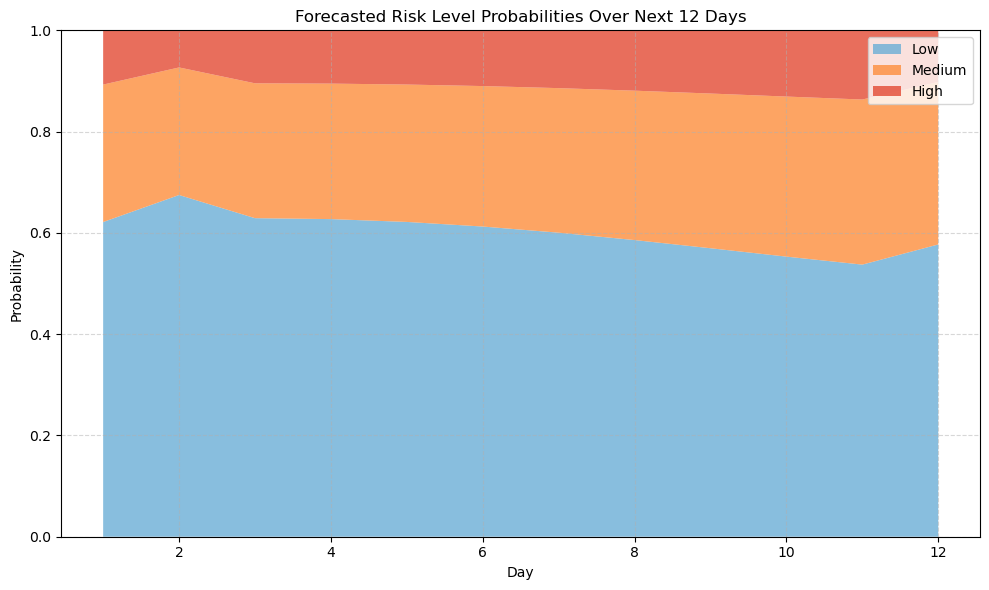

In [15]:
# Forecasting Risk for Future Periods

# Simulate future weather data (can use real data if available)
future_weather = np.random.binomial(1, 0.2, 12)  # Randomly generated weather for future (same probability as past)

# Extract posterior samples for risk prediction (traffic & weather coefficients)
beta_risk_1_samples = trace.posterior["beta_risk_1"].stack(sample=("chain", "draw")).values
beta_traffic_1_samples = trace.posterior["beta_traffic_1"].stack(sample=("chain", "draw")).values
beta_weather_1_samples = trace.posterior["beta_weather_1"].stack(sample=("chain", "draw")).values

beta_risk_2_samples = trace.posterior["beta_risk_2"].stack(sample=("chain", "draw")).values
beta_traffic_2_samples = trace.posterior["beta_traffic_2"].stack(sample=("chain", "draw")).values
beta_weather_2_samples = trace.posterior["beta_weather_2"].stack(sample=("chain", "draw")).values

# Compute forecast mean (for line plot)
beta_traffic_1_mean = beta_traffic_1_samples.mean()
beta_weather_1_mean = beta_weather_1_samples.mean()
beta_traffic_2_mean = beta_traffic_2_samples.mean()
beta_weather_2_mean = beta_weather_2_samples.mean()

# Expand weather and traffic for broadcasting
forecast_traffic_input = np.tile(forecast_y_traffic, (beta_traffic_1_samples.shape[0], 1))
future_weather_input = np.tile(future_weather, (beta_weather_1_samples.shape[0], 1))

# Compute logits
logit_0 = np.zeros_like(forecast_traffic_input)
logit_1 = beta_risk_1_samples[:, None] + beta_traffic_1_samples[:, None] * forecast_traffic_input + beta_weather_1_samples[:, None] * future_weather_input
logit_2 = beta_risk_2_samples[:, None] + beta_traffic_2_samples[:, None] * forecast_traffic_input + beta_weather_2_samples[:, None] * future_weather_input

# Stack logits and apply softmax
logits_all = np.stack([logit_0, logit_1, logit_2], axis=-1)
exp_logits = np.exp(logits_all - np.max(logits_all, axis=-1, keepdims=True))
p_risk_samples = exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

# Mean probabilities per class for each day
forecast_risk_probabilities = p_risk_samples.mean(axis=0)  # shape (12, 3)

# Show output
for i, probs in enumerate(forecast_risk_probabilities):
    print(f"Day {i+1}: Low={probs[0]:.2f}, Medium={probs[1]:.2f}, High={probs[2]:.2f}")

# Risk levels
days = np.arange(1, 13)
risk_labels = ["Low", "Medium", "High"]

# Transpose probabilities for plotting
risk_probs = forecast_risk_probabilities.T  # shape (3, 12)

# Plot stacked area chart
plt.figure(figsize=(10, 6))
plt.stackplot(days, risk_probs, labels=risk_labels, colors=["#6BAED6", "#FD8D3C", "#E34A33"], alpha=0.8)

plt.title("Forecasted Risk Level Probabilities Over Next 12 Days")
plt.xlabel("Day")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [16]:
# Define the Bayesian Network structure
# Creates a Bayesian network model named 'model' with the specified dependencies:
# Traffic and Weather directly influence Risk.
# Traffic directly influences AirQuality.
# AirQuality also influences Risk.
model = DiscreteBayesianNetwork([('Traffic', 'Risk'), ('Weather', 'Risk'), ('Traffic', 'AirQuality'), ('AirQuality', 'Risk')])

In [17]:
# Define the Conditional Probability Distributions (CPDs)
# CPDs specify the probability of each state of a variable given the states of its parents.
# variable: The name of the variable.
# variable_card: The number of possible states for the variable.
# values: A list of lists representing the probabilities. The order matters and depends on the evidence.
# evidence: A list of the parent variables.
# evidence_card: A list of the number of states for each parent variable (in the same order as 'evidence').
ram = {
    ('Low', 'Good', 0): [0.85, 0.10, 0.05],  # Low T, Good W, AQ=0: Low, Med, High
    ('Low', 'Good', 1): [0.75, 0.20, 0.05],  # Low T, Good W, AQ=1: Low, Med, High
    ('Low', 'Bad', 0):  [0.55, 0.35, 0.10],  # Low T, Bad W, AQ=0: Low, Med, High
    ('Low', 'Bad', 1):  [0.45, 0.45, 0.10],  # Low T, Bad W, AQ=1: Low, Med, High
    ('High', 'Good', 0): [0.65, 0.25, 0.10], # High T, Good W, AQ=0: Low, Med, High
    ('High', 'Good', 1): [0.55, 0.35, 0.10], # High T, Good W, AQ=1: Low, Med, High
    ('High', 'Bad', 0):  [0.25, 0.45, 0.30], # High T, Bad W, AQ=0: Low, Med, High
    ('High', 'Bad', 1):  [0.15, 0.55, 0.30], # High T, Bad W, AQ=1: Low, Med, High
}

# Define the order of evidence states for the columns in 'values'
evidence_order = [('Low', 'Good', 0), ('High', 'Good', 0), ('Low', 'Bad', 0), ('High', 'Bad', 0),
                  ('Low', 'Good', 1), ('High', 'Good', 1), ('Low', 'Bad', 1), ('High', 'Bad', 1)]

ram_values = np.array([list(ram[key]) for key in evidence_order]).T
cpd_traffic = TabularCPD(variable='Traffic', variable_card=2, values=[[0.7], [0.3]])
cpd_weather = TabularCPD(variable='Weather', variable_card=2, values=[[0.8], [0.2]])
cpd_air_quality = TabularCPD(variable='AirQuality', variable_card=2,
                             values=[[0.9, 0.6],  # P(AQ=0 | T=0, T=1)
                                     [0.1, 0.4]],
                             evidence=['Traffic'], evidence_card=[2])
cpd_risk = TabularCPD(variable='Risk', variable_card=3,
                     values=ram_values,
                     evidence=['Traffic', 'Weather', 'AirQuality'], evidence_card=[2, 2, 2])


In [18]:
# Add CPDs to the model
model.add_cpds(cpd_traffic, cpd_weather, cpd_air_quality, cpd_risk)
model.check_model()

True

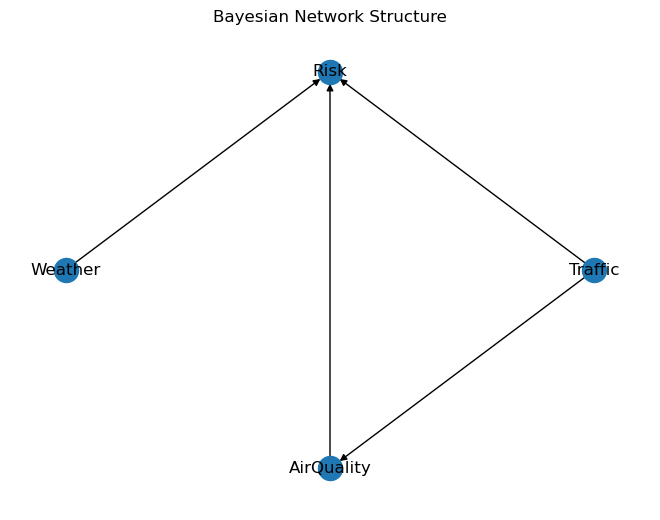

In [19]:
# Visualize the DAG
pos = nx.circular_layout(model)
nx.draw(model, pos=pos, with_labels=True)
plt.title("Bayesian Network Structure")
plt.show()

In [23]:
# Perform inference
predicted_risks = { 'Low': [], 'Medium': [], 'High': [] }
inference = VariableElimination(model)
threshold = 60
forecast_traffic_states = (forecast_samples_traffic > threshold).astype(int)

for i in range(forecast_traffic_states.shape[1]):
    traffic_states_for_day = forecast_traffic_states[:, i]
    predicted_risk_for_day = {'Low': [], 'Medium': [], 'High': []}

    for traffic_state in traffic_states_for_day:
        predicted_risk = inference.query(
            variables=['Risk'],
            evidence={'Traffic': traffic_state, 'Weather': future_weather[i], 'AirQuality': 0}
        )

        # Append probabilities for Low, Medium, and High
        predicted_risk_for_day['Low'].append(predicted_risk.values[0])  # Low risk
        predicted_risk_for_day['Medium'].append(predicted_risk.values[1])  # Medium risk
        predicted_risk_for_day['High'].append(predicted_risk.values[2])  # High risk

    # Append each day's risk probabilities
    for risk_level in predicted_risk_for_day:
        predicted_risks[risk_level].append(np.mean(predicted_risk_for_day[risk_level]))

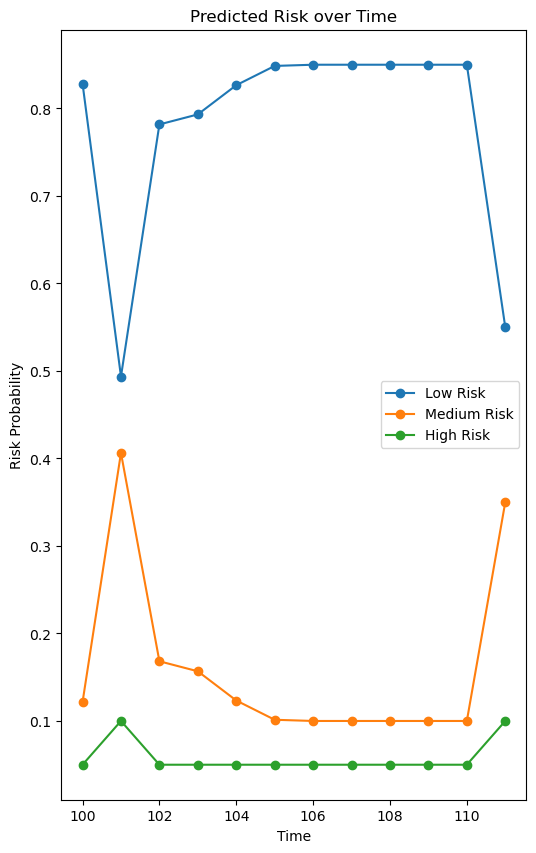

In [26]:
# Plot all risk levels in one chart
plt.figure(figsize=(6, 10))
for risk_level in predicted_risks:
    plt.plot(forecast_x, predicted_risks[risk_level], marker='o', linestyle='-', label=f"{risk_level} Risk")

plt.xlabel("Time")
plt.ylabel("Risk Probability")
plt.title("Predicted Risk over Time")
plt.legend()
plt.show()


1. Modeling:
PyMC:
PyMC uses probabilistic programming to define flexible models with probability distributions for variables. It’s particularly useful for situations with limited or noisy data, allowing for the modeling of complex relationships and uncertainty. In cases where the relationships between variables are uncertain, PyMC can infer the most likely values based on sampling techniques (e.g., MCMC). This allows it to model uncertainty and correlations dynamically.

pgmpy:
pgmpy focuses on probabilistic graphical models (Bayesian networks), where conditional probability distributions (CPDs) specify the relationships between variables. In contrast to PyMC, pgmpy relies on a predefined structure where the dependencies between variables are explicitly stated. RAM (Risk Assessment Matrix) would typically be integrated into pgmpy as part of the CPD values, defining the probability of each risk level based on the combination of traffic, weather, and air quality conditions. Thus, RAM provides the conditional probability tables for modeling risk levels but is more rigid in structure compared to PyMC.

2. Precision:
PyMC:
The precision in PyMC is driven by the data and sampling process. As it is based on posterior distributions, it provides a flexible approach to adjusting model parameters based on available data, offering more refined estimates as more data becomes available. Therefore, even with limited data, PyMC can infer the range and likelihood of model parameters using prior knowledge. However, it performs better with a larger dataset, where the posterior distribution becomes more accurate, enhancing the model’s predictive capability.

pgmpy:
In pgmpy, precision is more dependent on the CPDs defined for the model. The accuracy of predictions is directly tied to the quality of the dependencies (e.g., RAM in the context of risk assessment). While pgmpy is well-suited for scenarios with clearly defined relationships, its precision does not benefit from the same data-driven adaptability that PyMC offers.

3. Flexibility:
PyMC:
PyMC offers high flexibility, allowing the model to adjust and learn from new data as it becomes available. It excels in dynamic, uncertain environments where the relationships between variables may not be fully known or may evolve over time.

pgmpy:
While pgmpy is powerful for modeling structured relationships, it is less flexible than PyMC. The model structure in pgmpy is predefined (e.g., RAM matrices for risk levels), and while it can represent complex dependencies, it doesn't adapt to new data as fluidly as PyMC does. This makes pgmpy more suited for cases with well-defined relationships that don't change frequently.